<a href="https://colab.research.google.com/github/ahmadharimukti/contohbaru/blob/main/bert_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bert-LTSM-CNN

In [48]:
# Some pip install for BERT
!pip install bert-for-tf2

In [49]:
# Import all dependencies to be used

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # machine learning and neural nets
import tensorflow_datasets as tfds # for text preprocessing
import tensorflow_hub as hub
import bert
from nltk.sentiment.vader import SentimentIntensityAnalyzer # NLTK class object for determining sentiment of text

In [50]:
#Mount your drive account into colab

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [52]:
df = pd.read_csv('drive/My Drive/Colab Notebooks/data/Twitter Spam/trainkedua.csv')
df.head()

,Tweet,following,followers,actions,is_retweet,location,Type,Unnamed: 7
0,Good Morning Love @LeeBrown_V,0.0,0.0,0.0,0.0,"Pennsylvania, USA",1,NaN
1,'@realDonaldTrump @USNavy RIP TO HEROES',42096.0,61060.0,5001.0,0.0,"South Padre Island, Texas",0,NaN
2,Haven't been following the news but I understa...,0.0,0.0,NaN,0.0,Will never be broke ever again,1,NaN
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,0.0,0.0,0.0,0.0,Mundo,1,NaN
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,17800.0,35100.0,NaN,0.0,"Nottingham, England",1,NaN


In [53]:
# Check the description and information relevant from the train.csv dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14899 entries, 0 to 14898
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Tweet       14899 non-null  object 
 1   following   14741 non-null  float64
 2   followers   14882 non-null  float64
 3   actions     11462 non-null  float64
 4   is_retweet  14898 non-null  float64
 5   location    12888 non-null  object 
 6   Type        14899 non-null  int64  
 7   Unnamed: 7  0 non-null      float64
dtypes: float64(5), int64(1), object(2)
memory usage: 931.3+ KB
None


# Text Cleaning and BERT Prep

In [54]:
# Import dependency for string cleaning
import re

# Grab a sample string for display purposes
text_str = df.loc[984,'Tweet']

def clean_text(text):
    '''
    Function to clean text and remove unnecessary components and ease tokenization.
    :param: text: the string to be cleaned
    :output: text: the cleaned string
    '''
    text = re.sub(r'https?://\S+', '', text) # remove link
    text = re.sub(r'#\w+', '', text) # remove hashtags
    text = re.sub(r'@\w+', '', text) # remove mentions
    text = re.sub(r'\n', ' ', text) # remove linebreaks
    text = re.sub(r'\s+', ' ', text) # remove leading and trailing spaces
    return text

# Show the cleaned version of the sample text
print(f'Starting text: {text_str}')
print(f'Cleaned text: {clean_text(text_str)}')

Starting text: Very much worth reading: Joseph Epstein pays tribute to Michael Oakeshott.   http://t.co/n3Y4VCmMCv
Cleaned text: Very much worth reading: Joseph Epstein pays tribute to Michael Oakeshott. 


In [55]:
def bert_encoding(texts, tokenizer, max_len=512):
    '''
    Function to encode text into tokens, masks, and segment_ids for BERT embedding layer input.
    
    :param: texts - the texts to tokenize
    :param: tokenizer - the BERT tokenizer that will be used to tokenize the texts
    :param: max_len - the maximum length of an input sequence (the sequence of tokens to be embedded)
    
    :output: all_tokens - the texts turned into tokens and padded for match length, returned as np.array
    :output: all_masks - masks for each text denoted sequence length and pad length, returned as np.array
    :output: all_segments - segment_ids for each text, all blank, returned as np.array
    '''
    all_tokens = [] # initiated list for tokens
    all_masks = [] # initiated list for masks
    all_segments = [] # initiated list for segment_ids
    
    # Iterate through all texts
    for text in texts:
        
        # Tokenize text
        text = tokenizer.tokenize(text)
        
        # Make room for the CLS and SEP tokens
        text = text[:max_len-2]
        
        # Create the input sequence beginning with [CLS] and ending with [SEP]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        
        # Determine how much padding is required (max_length - length of the input sequence)
        pad_len = max_len - len(input_sequence)
        
        # Create token ids, used by BERT
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        
        # Pad the tokens by 0's for the pad length determined above
        tokens += [0] * pad_len
        
        # Create the masks for the sequence, with the 1 for each token id and 0 for all padding
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        
        # All empty segment_ids for the max length
        segment_ids = [0] * max_len
        
        # Append all tokens, masks, and segment_ids to the initialized lists
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [57]:
# Initialize the tokenizer
BertTokenizer = bert.bert_tokenization.FullTokenizer

# Load the BERT layer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)

# Import the vocab files, and the lower case function
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

# Load the tokenizer with the preloaded vocab file and lower case function
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

# Give a sample of how the tokenizer works
tokenizer.tokenize("What cool code, where'd ya learn it all?")

['what',
 'cool',
 'code',
 ',',
 'where',
 "'",
 'd',
 'ya',
 'learn',
 'it',
 'all',
 '?']

In [58]:
df["Type"].value_counts()

1    7455
0    7444
Name: Type, dtype: int64

In [59]:
# Clean the text data
df['text_clean'] = df['Tweet'].apply(lambda x: clean_text(x))

# Lowercase the text data
df['text_lowered'] = df['text_clean'].apply(lambda x: x.lower())

# Set targets
targets = df['Type']

In [60]:
# Load dependency for train_test_split function
from sklearn.model_selection import train_test_split

# Prepare the X and Y train and test datasets
X_train,X_test,Y_train,Y_test = train_test_split(list(df['text_lowered']),targets,test_size=0.2,random_state=28)

In [61]:
# Finally, run the X train and test (the cleaned and lowered text data) through the BERT encoding function
# with the BERT tokenizer we prepped and a max_len parameter chosen by you
train_input = bert_encoding(X_train, tokenizer, max_len=100)
test_input = bert_encoding(X_test, tokenizer, max_len=100)

# Building the Model and Testing

In [62]:
def build_model(bert_layer, max_len=512):
    '''
    Function to build a tensorflow machine learning neural network model.
    
    :param: bert_layer - the loaded BERT layer from TF hub
    :param: max_len - the maximum length of an input sequence for encoding purposes, used here to denote the input shape
    
    :output: Model - Tensorflow keras model with inputs and outputs designated
    '''
    # INPUTS
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name='input_word_ids')
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name='input_mask')
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name='segment_ids')
    
    # BERT EMBEDDING
    _, sequence_output = bert_layer([input_word_ids,input_mask,segment_ids])
    clf_output = sequence_output[:, 0, :]
    clf_output_ = tf.keras.layers.Reshape((32,24))(clf_output)
    
    # HIDDEN
    hidden = tf.keras.layers.Dense(128,activation='relu')(clf_output)
    hidden2 = tf.keras.layers.Dense(64,activation='relu')(hidden)
    drop = tf.keras.layers.Dropout(0.1)(hidden2)
    
    # CHANNEL 2 - LSTM
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,
                                kernel_regularizer=tf.keras.regularizers.L2(0.001),
                                                             return_sequences=True))(clf_output_)
    drop2 = tf.keras.layers.Dropout(0.1)(lstm)
    cnn = tf.keras.layers.Conv1D(64,5,
                                kernel_regularizer=tf.keras.regularizers.L2(0.001))(drop2)
    max_pool = tf.keras.layers.MaxPooling1D(25)(cnn)
    flat = tf.keras.layers.Flatten(data_format='channels_last')(max_pool)
    
    # OUTPUTS
    concat = tf.keras.layers.Concatenate()([drop,flat])
    output_target = tf.keras.layers.Dense(1,activation='sigmoid')(concat)
    
    return tf.keras.Model(inputs=[input_word_ids,input_mask,segment_ids],outputs=output_target)

In [63]:
# Build the model
model = build_model(bert_layer,max_len=100)

In [64]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 100)]        0           []                               
                                                                                                  
 keras_layer_3 (KerasLayer)     [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 100, 768)]                'input_mask[0][0]',       

In [65]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-6),loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC()])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


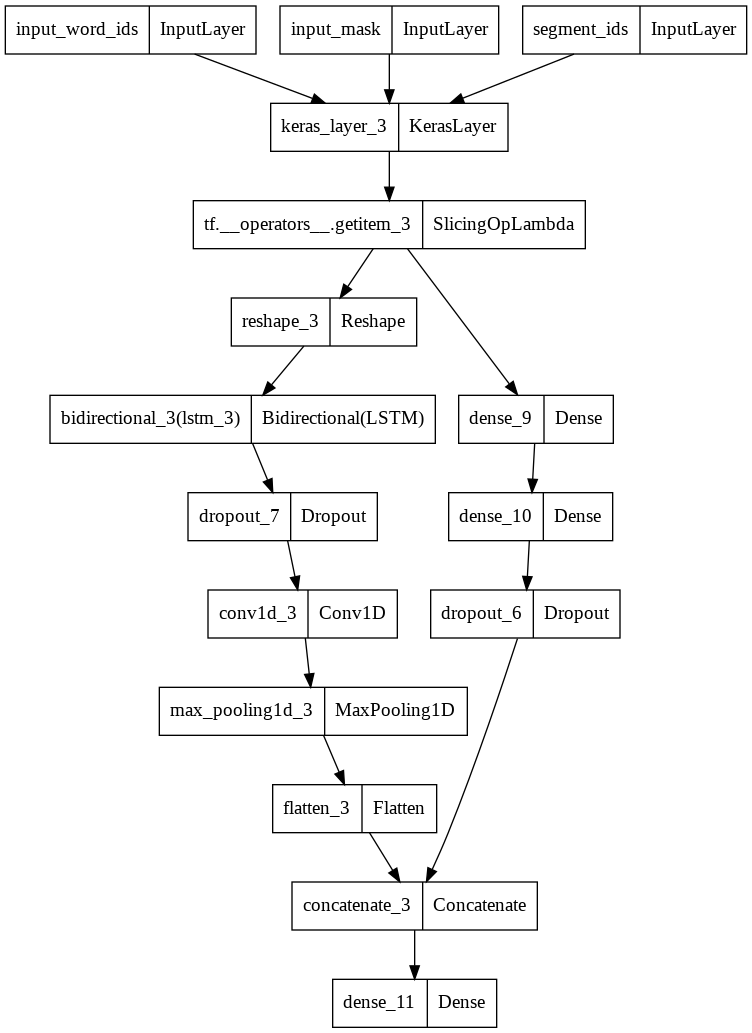

In [66]:
tf.keras.utils.plot_model(model)

In [67]:
train_history = model.fit(train_input,Y_train,epochs=3,batch_size=16,validation_split=0.2)


Epoch 1/3
596/596 [==============================] - 4280s 7s/step - loss: 0.8710 - accuracy: 0.5769 - auc_3: 0.6055 - val_loss: 0.8526 - val_accuracy: 0.6388 - val_auc_3: 0.6981
Epoch 2/3
596/596 [==============================] - 4280s 7s/step - loss: 0.8363 - accuracy: 0.6523 - auc_3: 0.7207 - val_loss: 0.8203 - val_accuracy: 0.6833 - val_auc_3: 0.7685
Epoch 3/3
596/596 [==============================] - 4299s 7s/step - loss: 0.8057 - accuracy: 0.6946 - auc_3: 0.7747 - val_loss: 0.7923 - val_accuracy: 0.7055 - val_auc_3: 0.7967


In [68]:
predictions = model.predict(test_input)

In [69]:
from sklearn.metrics import classification_report, confusion_matrix

def pred_return(x):
    if x>=0.5:
        return 1
    else:
        return 0

print(classification_report([pred_return(x) for x in predictions],Y_test))
print(confusion_matrix([pred_return(x) for x in predictions],Y_test))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72      1384
           1       0.77      0.72      0.74      1596

    accuracy                           0.73      2980
   macro avg       0.73      0.73      0.73      2980
weighted avg       0.73      0.73      0.73      2980

[[1030  354]
 [ 442 1154]]


In [70]:
test_df = pd.read_csv('drive/My Drive/Colab Notebooks/data/Twitter Spam/test.csv')

In [71]:
test_df.head()

,Id,Tweet,following,followers,actions,is_retweet,location
0,0,"Cops shoot blacks almost everyday, and there a...",5509.0,5977.0,8062.0,1,ですpacito
1,1,"#HAPPYTAEYANGDAY Oppa,happy birthday to you, ...",0.0,0.0,NaN,0,NaN
2,2,RT @HoneyBadger10: Panthers in the super bowl....,471.0,229.0,747.0,0,"B'klyn, NYC, LA"
3,3,Sorry my Twitter keeps posting my retweets a m...,0.0,79800.0,48.0,0,NaN
4,4,Heart attack causes and symptoms are different...,902.0,5797.0,4270.0,0,Chicago


In [73]:
test_df['text_clean'] = test_df['Tweet'].apply(lambda x: clean_text(x))
test_df['text_lowered'] = test_df['text_clean'].apply(lambda x: x.lower())

In [74]:
test_input = bert_encoding(test_df['text_lowered'],tokenizer,max_len=50)

In [76]:
predictions = model.predict(test_input)
test_df['Type'] = [pred_return(x) for x in predictions]
test_df.drop(['Tweet','following','followers','actions','is_retweet','location','text_clean','text_lowered'],axis=1,inplace=True)
test_df.head()

ValueError: ignored

In [ ]:
assert len(test_df['target']) == 3263

In [ ]:
test_df.to_csv('submission.csv',index=False,header=True)
